In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

#Make NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.python.keras import layers

print(tf.__version__)



2.9.1


In [69]:
#Data formatting
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()


dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')



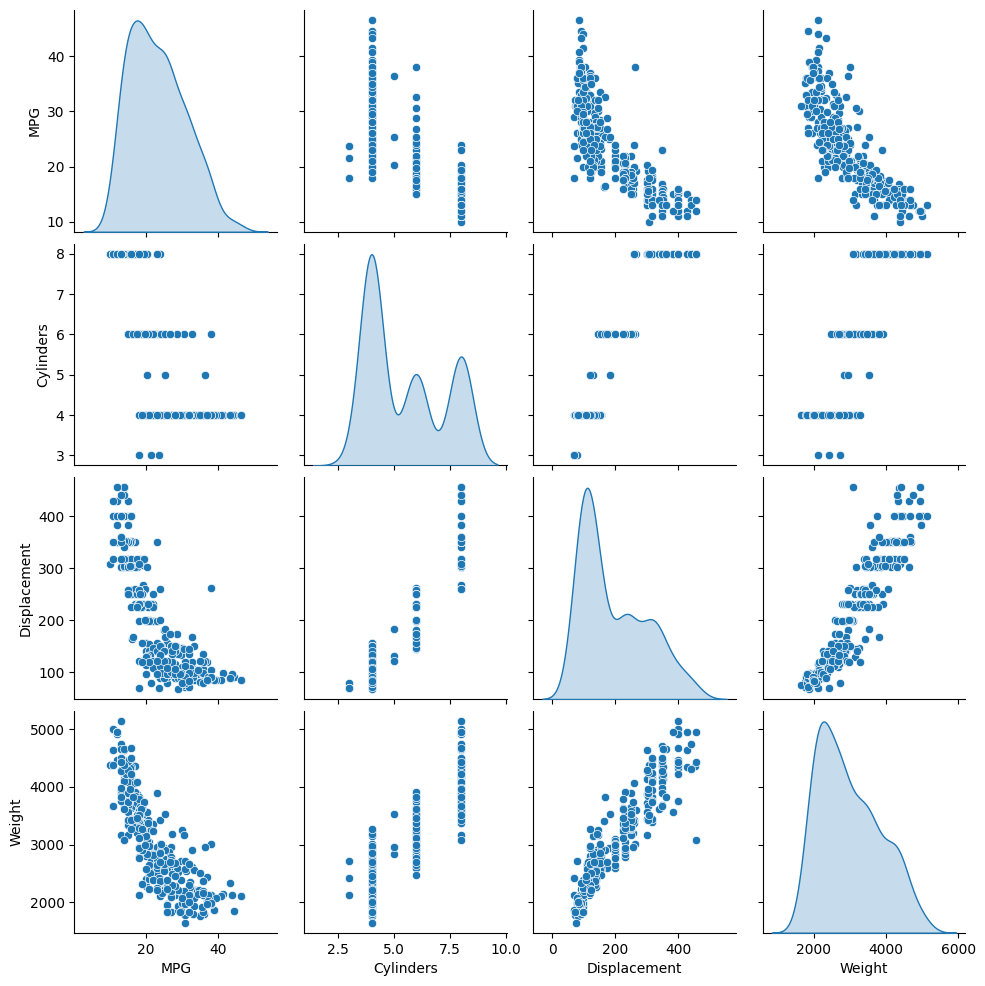

In [70]:
#show plots of all the data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
# plt.show(block=True) used to show rendered plots

In [71]:
# Normalizing is good practice i think

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 module_wrapper_23 (ModuleWr  (None, 1)                2         
 apper)                                                          
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [72]:
#Untrained guess
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 37ms/step


array([[ 0.948],
       [ 0.536],
       [-1.75 ],
       [ 1.329],
       [ 1.202],
       [ 0.472],
       [ 1.424],
       [ 1.202],
       [ 0.313],
       [ 0.536]], dtype=float32)

In [73]:
horsepower_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [74]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Supress logging
    verbose=0,
    # Calculate validation results on 20% of training data
    validation_split = 0.2
)

CPU times: total: 3.83 s
Wall time: 3.04 s


In [75]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806583,4.186458,95
96,3.806259,4.217113,96
97,3.804023,4.196524,97
98,3.805258,4.174962,98
99,3.804875,4.186573,99


In [76]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

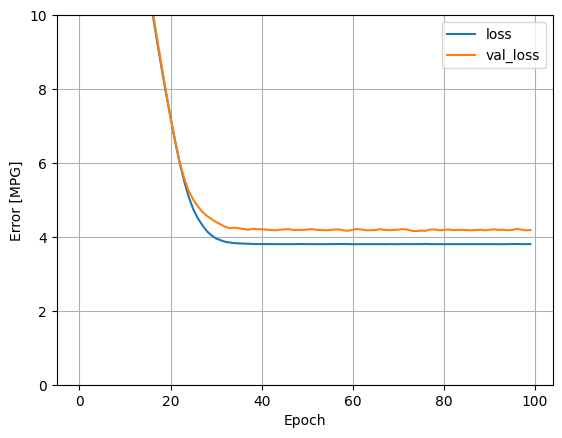

In [77]:
plot_loss(history)

In [78]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [79]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 857us/step


In [80]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

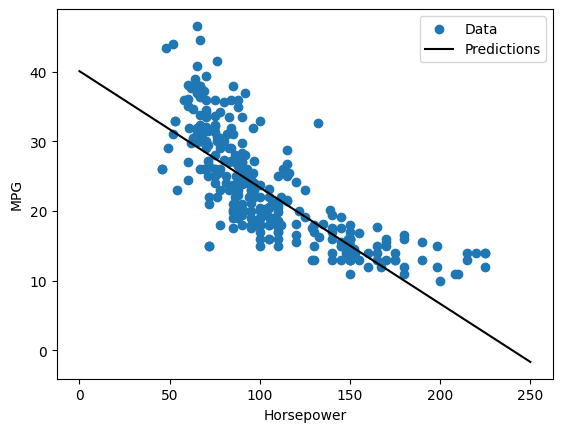

In [81]:
plot_horsepower(x, y)

In [82]:
#now do that with multiple inputs, we just make m a matrix and b a vector
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 40ms/step


array([[-1.033],
       [ 0.229],
       [ 0.849],
       [ 0.364],
       [-0.76 ],
       [ 1.001],
       [-0.761],
       [ 0.814],
       [ 0.203],
       [-1.893]], dtype=float32)

In [83]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [84]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
    )

CPU times: total: 4 s
Wall time: 2.98 s


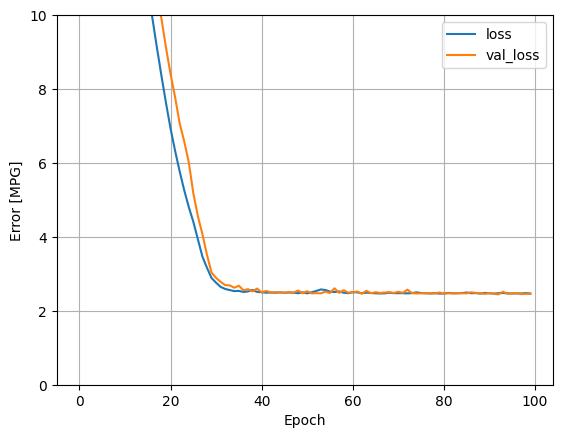

In [85]:
#less error. Yay.
plot_loss(history)

In [86]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [87]:
#Now we get to cool stuff
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [88]:
#single input
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

# dnn_horsepower_model.summary() # more inputs yippeee

In [89]:
%%time
#training
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 4.27 s
Wall time: 3.07 s


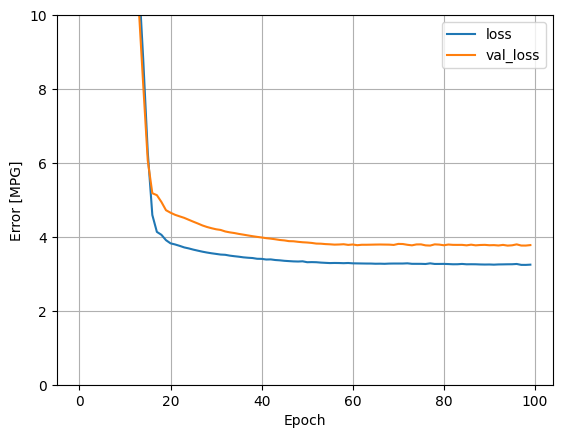

In [90]:
#output data
plot_loss(history)

8/8 [==============================] - 0s 857us/step


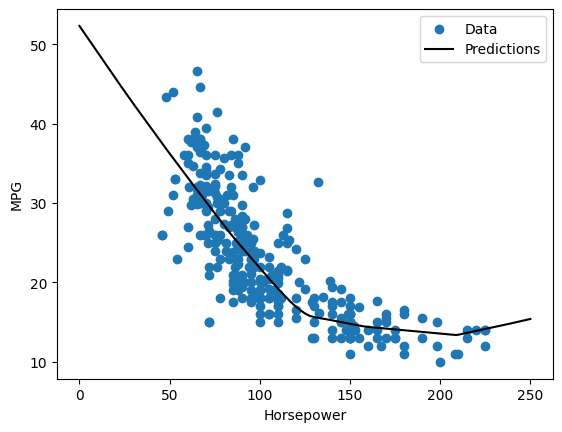

In [91]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [92]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [93]:
#dnn with multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 module_wrapper_28 (ModuleWr  (None, 64)               640       
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 64)               4160      
 apper)                                                          
                                                                 
 module_wrapper_30 (ModuleWr  (None, 1)                65        
 apper)                                                          
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-train

In [94]:
%%time
#training
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 3.91 s
Wall time: 2.96 s


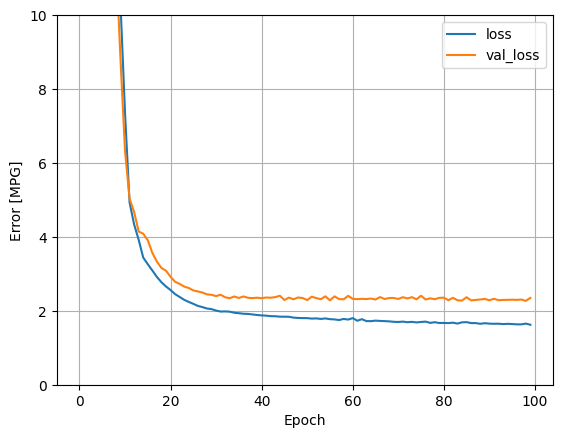

In [95]:
#output data
plot_loss(history)

In [96]:
#collect
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [97]:
#Comparison time!!!
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648764
linear_model,2.498341
dnn_horsepower_model,2.918710
dnn_model,1.718281


3/3 [==============================] - 0s 2ms/step


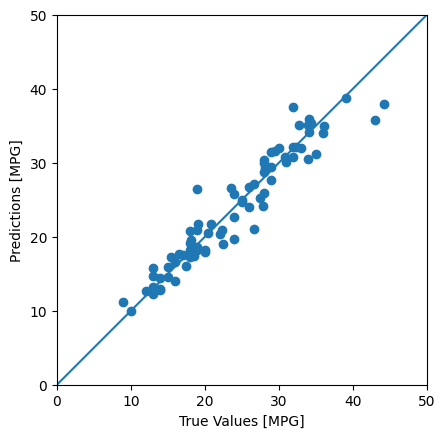

In [98]:
#PREDICTION TIME!!!!!!!!!
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

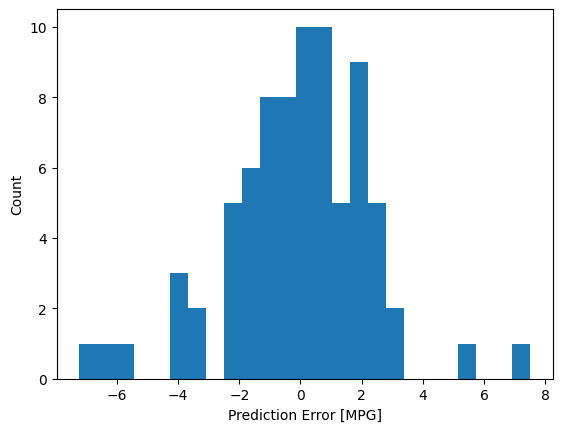

In [99]:
#Time to look at the error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [100]:
#Hey that model is pretty darn good. Time to save it!!!
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets


In [101]:
#Testing out reloading models cus ill need it later
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [102]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648764
linear_model,2.498341
dnn_horsepower_model,2.918710
dnn_model,1.718281
reloaded,1.718281
